# Smoothing Options Comparison

In this notebook, I will be comparing how multiple different ways to separate the mean-scale shape of a profile from smaller pertubations. These methods include:
- polynomial fit
- filtering
- averaging

I'm selecting a region near the Irminger Sea to compare with Figures 3 and 5 of Castro 2024. Look at both profiles of the tracer and the vertical gradient of the tracer

In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter

In [45]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import processing_funcs as prf
import filt_funcs as ff

### Get Irms box

In [9]:
#irms_box = [-45,-25,55,70,0,2001]
#ds = prf.get_box(irms_box,2)

loading points complete


/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/argopy/data_fetchers/gdac_data.py:331: UserWarning: Found more than 50 files to load, this may take a while to process sequentially ! Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time.
  warnings.warn(
 96%|█████████▌| 454/475 [20:14<00:58,  2.79s/it]/home.ufs/amf2288/mambaforge-pypy3/envs/Argo_Nov_24/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
100%|██████████| 475/475 [21:21<00:00,  2.70s/it]


to xarray complete
point to profile complete
interpolation complete
adding spice complete
adding MLD complete


In [173]:
#ds = ds.assign_attrs({"Fetched_uri":''})
#ds = ds.assign_attrs({"raw_attrs":''})

In [170]:
#ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/castro2024")

In [171]:
ds = xr.open_dataset("/swot/SUM05/amf2288/sync-boxes/castro2024")

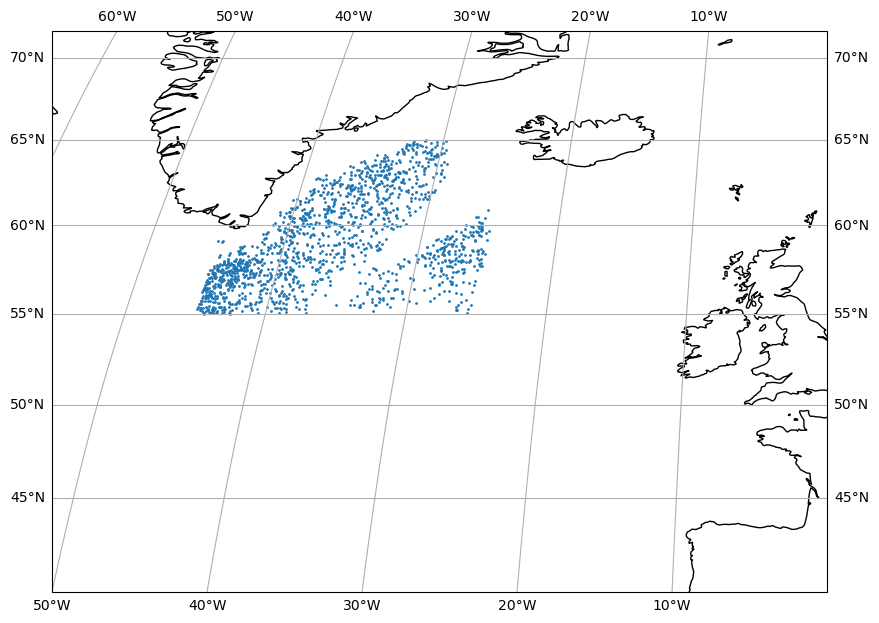

In [172]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_extent([-50,0,40,70])
ax.gridlines(draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',label='Section 1: Western North Atlantic',s=1)

### Apply Smoothing Methods

In [178]:
n=32
var='CT'
prof = ds.isel(N_PROF=n)[var]

In [191]:
#polynomial fit
degree = 20
coeff = np.polyfit(prof.PRES_INTERPOLATED.values, prof, degree)
polynomial = np.poly1d(coeff)
poly = polynomial(ds.PRES_INTERPOLATED.values)

/tmp/ipykernel_66861/2101234286.py:3: RankWarning: Polyfit may be poorly conditioned
  coeff = np.polyfit(prof.PRES_INTERPOLATED.values, prof, degree)


In [202]:
#filtering
lfilter=100
nfilter = ff.get_nfilter(ds, lfilter)
filt = filter.gaussian_filter1d(prof,sigma=nfilter,mode='nearest')

In [203]:
#spatial averaging
lat_min,lat_max,lon_min,lon_max = prof.LATITUDE-2,prof.LATITUDE+2,prof.LONGITUDE-2,prof.LONGITUDE+2 
ds_box = ds.where((ds.LATITUDE >= lat_min) & (ds.LATITUDE <= lat_max) & (ds.LONGITUDE >= lon_min) & (ds.LONGITUDE <= lon_max), drop=True)
spav = ds_box[var].mean('N_PROF')

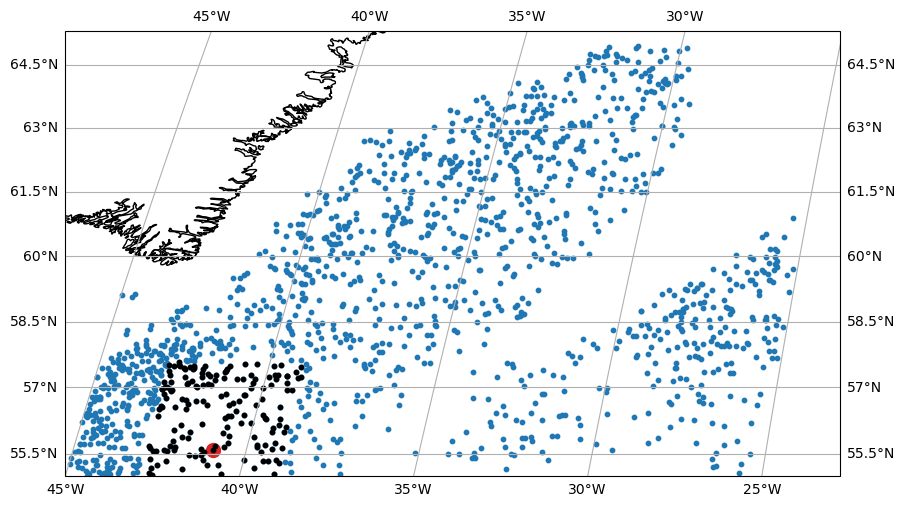

In [204]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.set_extent([-45,-25,55,65])
ax.gridlines(draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=10)
ax.scatter(prof.LONGITUDE,prof.LATITUDE,transform=ccrs.PlateCarree(),color='tab:red',s=100)
ax.scatter(ds_box.LONGITUDE,ds_box.LATITUDE,transform=ccrs.PlateCarree(),color='k',s=10)

### Compare Profiles

In [205]:
prof_grad = np.gradient(prof)
poly_grad = np.gradient(poly)
filt_grad = np.gradient(filt)
spav_grad = np.gradient(spav)

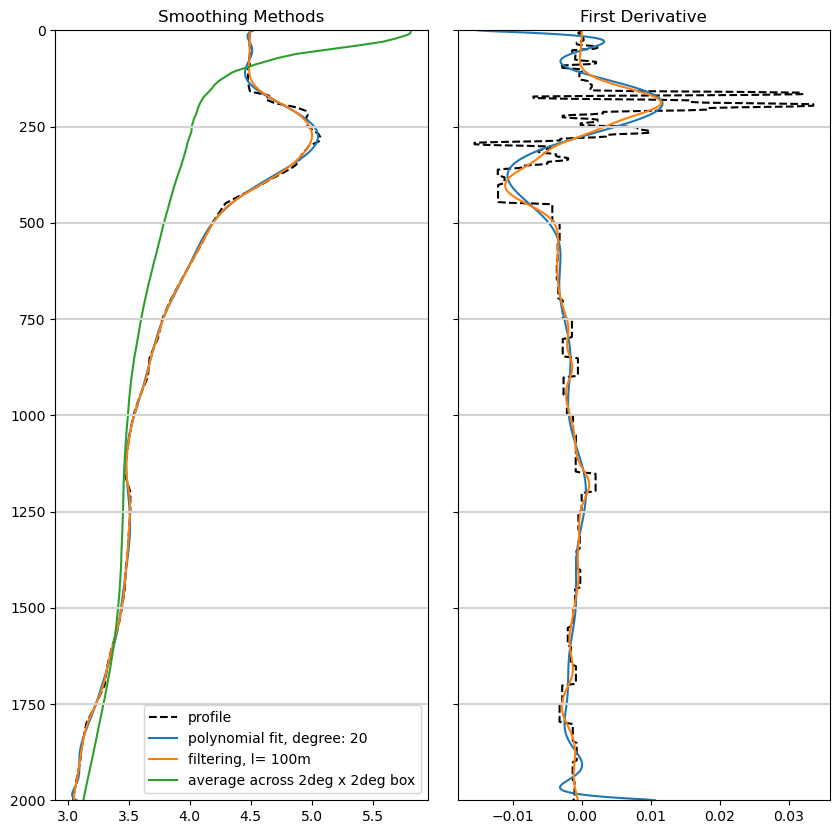

In [206]:
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.plot(prof.values, prof.PRES_INTERPOLATED.values, color='k', linestyle='--', label='profile')
plt.plot(poly, prof.PRES_INTERPOLATED.values, label='polynomial fit, degree: {}'.format(degree))
plt.plot(filt, prof.PRES_INTERPOLATED.values, label='filtering, l= {}m'.format(lfilter))
plt.plot(spav, prof.PRES_INTERPOLATED.values, label='average across 2deg x 2deg box')
#plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.legend()
for y in np.arange(0,2000,250):
    plt.axhline(y,color='lightgray')
plt.title('Smoothing Methods')

plt.subplot(122)
plt.plot(prof_grad, prof.PRES_INTERPOLATED.values, color='k', linestyle='--', label='profile')
plt.plot(poly_grad, prof.PRES_INTERPOLATED.values, label='polynomial fit, degree: {}'.format(degree))
plt.plot(filt_grad, prof.PRES_INTERPOLATED.values, label='filtering, l= {}m'.format(lfilter))
#plt.plot(spav_grad, prof.PRES_INTERPOLATED.values, label='average across 2deg x 2deg box')
#plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.yticks(labels='',ticks=np.arange(0,2000,250))
for y in np.arange(0,2000,250):
    plt.axhline(y,color='lightgray')
plt.title('First Derivative')

plt.subplots_adjust(wspace=0.08)

- try over the same depth regions as this paper
- continue testing different methods, especially with the synthetic profile notebook where you can control the amount of variance
- compare different orders and different filter scales
- instead of picking box around profile, look at Roemmich & Gilson argo climatology by month